# DBAC main result plot

## 1. Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import sys
sys.path.append('..')
from functions.qite_gci import *
from functions.qite_dme import *
from functions.plot_bloch_sphere import *

pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.
jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
              "CQG": {"onecol": 374.*pt}, # CQG is only one column
              # Add more journals below. Can add more properties to each journal
             }

my_width = jour_sizes["PRD"]["onecol"]
# Our figure's aspect ratio
golden = 5.5/3.5
# Plot config
plt.rcParams.update({
    # 'axes.labelsize': 16,
    # 'axes.titlesize': 16,
    'font.size': 10,
    'savefig.dpi': 75,
    'lines.linewidth': 2.0,
    'lines.markersize': 8,
    # 'legend.fontsize': 10,
    'legend.labelspacing': .3,
    'legend.columnspacing': .3,
    'legend.handletextpad': .1,
    'text.usetex': True,
    'font.family': "serif",
    'font.serif': "Times",
    'figure.figsize': [my_width,my_width/golden],
    'figure.autolayout': True
})

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

[Qibo 0.2.16|INFO|2025-08-21 16:49:16]: Using numpy backend on /CPU:0


---
## 2. Run DB-QITE with DME

In [2]:
optimal_s_Mk = np.load('optimal_s_Mk.npy')

0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --

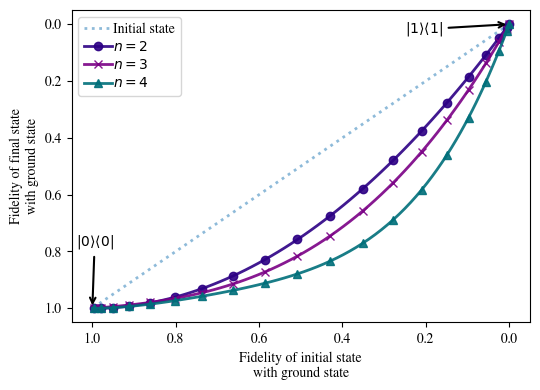

In [3]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.linalg import expm

# --- Plot/text config (no external LaTeX) ---
mpl.rcParams['text.usetex'] = False

# --- Setup ---
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
thetas = np.linspace(0, 1, 100)
ket1 = np.array([[0.0], [1.0]], dtype=complex)
psis = np.array([expm(-1j * np.pi/2 * sigma_x * t) @ ket1 for t in thetas])
state_0 = np.array([1.0, 0.0], dtype=complex)
target_fidelity = 0.9

def fidelity_with_0(state):
    psi = np.ravel(state).astype(complex)   # shape (2,)
    amp = np.vdot(state_0, psi)             # <0|psi>
    return float(np.real_if_close(abs(amp)**2))

fidelities_original = np.array([fidelity_with_0(psi) for psi in psis])

# Make the line-search grid reasonable
s_grid = np.linspace(0.0, 1.0, 101)

# Example initial energies (adjust to your API)
res_init = []
for psi in psis:
    E = GCI(initial_psi, psi, 1, s_grid).execute_gci()[0][-1]
    E = np.real_if_close(E)
    res_init.append(E)

def run_dbqite(label_map, k, psis):
    results = {}
    for M, label in label_map.items():
        s_vals = optimal_s_Mk[M-1][:k] if k <= len(optimal_s_Mk[M-1]) else s_grid
        energies = []
        for psi in psis:
            E = GCI(QITE_dme_select_M(M), psi, None, s_vals).execute_gci()[0][-1]
            energies.append(np.real_if_close(E))
        fids = np.clip((1 - np.array(energies))/2, 0, 1)
        results[label] = fids
    return results

dict_fid_RGCI_1 = run_dbqite({1: r'$n=2$', 2: r'$n=3$'}, k=1, psis=psis)
dict_fid_RGCI_2 = run_dbqite({1: r'$n=4$'}, k=2, psis=psis)

# --- Plot ---
fig, ax = plt.subplots(figsize=(5.5, 4))
ax.plot(fidelities_original, fidelities_original,
        label="Initial state", alpha=0.5, linestyle=':')

colors = ['#2c0084', '#7a0085', '#006f7a', 'C0']
markers = ['o', 'x', '^', 's']

for i, (label, fid) in enumerate(dict_fid_RGCI_1.items()):
    ax.plot(fidelities_original, fid, label=label, color=colors[i],
            marker=markers[i], markevery=5, markersize=6, alpha=0.9)

for i, (label, fid) in enumerate(dict_fid_RGCI_2.items()):
    ax.plot(fidelities_original, fid, label=label, color=colors[i+2],
            marker=markers[i+2], markevery=5, markersize=6, alpha=0.9)

ax.invert_xaxis()
ax.invert_yaxis()

ax.set_xlabel('Fidelity of initial state\nwith ground state')
ax.set_ylabel('Fidelity of final state\nwith ground state')
ax.legend()

# Use a specific series for annotations
first_label = next(iter(dict_fid_RGCI_1))
ref_series = dict_fid_RGCI_1[first_label]

ax.annotate(r'$|1\rangle\langle 1|$',
            xy=(fidelities_original[0], ref_series[0]),
            xytext=(fidelities_original[0]+0.25, ref_series[0]+0.03),
            arrowprops=dict(arrowstyle='->', lw=1.5))
ax.annotate(r'$|0\rangle\langle 0|$',
            xy=(fidelities_original[-1], ref_series[-1]),
            xytext=(fidelities_original[-1]+0.04, ref_series[-1]-0.22),
            arrowprops=dict(arrowstyle='->', lw=1.5))

plt.tight_layout()

os.makedirs('plots', exist_ok=True)
plt.savefig('plots/3_circuit_fid.pdf')

0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --

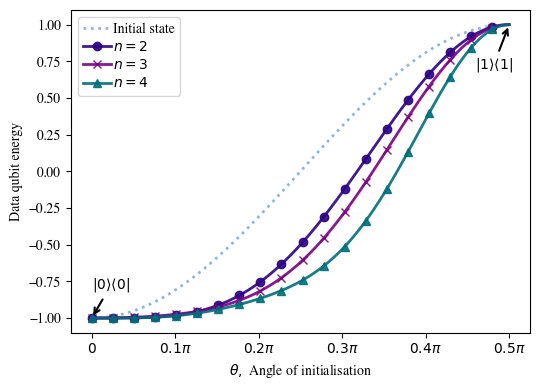

In [4]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.linalg import expm
import matplotlib.ticker as ticker

# --- Plot/text config: use mathtext, not external LaTeX ---
mpl.rcParams['text.usetex'] = False

# --- Setup ---
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
thetas = np.linspace(0.0, 1.0, 100)
ket0 = np.array([[1.0], [0.0]], dtype=complex)
psis = np.array([expm(-1j * np.pi/2 * sigma_x * t) @ ket0 for t in thetas])

state_0 = np.array([1.0, 0.0], dtype=complex)

# Use None when you don't actually want a target line;
# if you keep a numeric value, it will be drawn only if finite.
target_fidelity = None  # was -1

# --- Robust fidelity helper ---
def fidelity_with_0(state):
    psi = np.ravel(state).astype(complex)  # shape (2,)
    amp = np.vdot(state_0, psi)            # <0|psi>
    return float(np.real_if_close(abs(amp)**2))

fidelities_original = np.array([fidelity_with_0(psi) for psi in psis])

# --- A reasonable line-search grid for GCI (interior points!) ---
s_grid = np.linspace(0.0, 1.0, 101)

# --- Initial energies (force to real) ---
res_init = []
for psi in psis:
    E = GCI(initial_psi, psi, 1, s_grid).execute_gci()[0][-1]
    res_init.append(float(np.real_if_close(E)))
res_init = np.array(res_init)

# --- DB-QITE results: keep energies, ensure real ---
def run_dbqite(label_map, k, psis):
    results = {}
    for M, label in label_map.items():
        # If optimal_s_Mk is shorter than k, fall back to s_grid
        try:
            s_vals = optimal_s_Mk[M-1][:k]
            if len(s_vals) == 0:
                s_vals = s_grid
        except Exception:
            s_vals = s_grid

        energies = []
        for psi in psis:
            E = GCI(QITE_dme_select_M(M), psi, None, s_vals).execute_gci()[0][-1]
            energies.append(float(np.real_if_close(E)))
        results[label] = np.array(energies)
    return results

dict_fid_RGCI_1 = run_dbqite({1: r'$n=2$', 2: r'$n=3$'}, k=1, psis=psis)
dict_fid_RGCI_2 = run_dbqite({1: r'$n=4$'}, k=2, psis=psis)

# --- Plot ---
xvals = thetas * (np.pi / 2)  # angle

fig, ax = plt.subplots(figsize=(5.5, 4))
ax.plot(xvals, res_init, label="Initial state", alpha=0.5, linestyle=':')

colors  = ['#2c0084', '#7a0085', '#006f7a', 'C0']
markers = ['o', 'x', '^', 's']

for i, (label, energies) in enumerate(dict_fid_RGCI_1.items()):
    ax.plot(xvals, energies, label=label, color=colors[i],
            marker=markers[i], markevery=5, markersize=6, alpha=0.9)

for i, (label, energies) in enumerate(dict_fid_RGCI_2.items()):
    ax.plot(xvals, energies, label=label, color=colors[i+2],
            marker=markers[i+2], markevery=5, markersize=6, alpha=0.9)

# Target line (only if provided & finite)
if target_fidelity is not None and np.isfinite(target_fidelity):
    ax.axhline(y=float(target_fidelity), color='k', alpha=0.6, linestyle='--')

ax.set_xlabel(r'$\theta,$ Angle of initialisation')
ax.set_ylabel('Data qubit energy')
ax.legend()

# Annotations (use res_init as the reference curve)
ax.annotate(r'$|1\rangle\langle 1|$',
            xy=(xvals[-1], res_init[-1]),
            xytext=(xvals[-1]-0.13, res_init[-1]-0.3),
            arrowprops=dict(arrowstyle='->', lw=1.5))

ax.annotate(r'$|0\rangle\langle 0|$',
            xy=(xvals[0], res_init[0]),
            xytext=(xvals[0], res_init[0]+0.2),
            arrowprops=dict(arrowstyle='->', lw=1.5))

# Ticks as requested
ticks = np.linspace(0.0, np.pi/2, 6)
tick_labels = [r'$0$', r'$0.1\pi$', r'$0.2\pi$', r'$0.3\pi$', r'$0.4\pi$', r'$0.5\pi$']
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

plt.tight_layout()

# Ensure output directory exists
os.makedirs('plots', exist_ok=True)
plt.savefig('plots/3_circuit_energy_theta.pdf')

In [9]:
# Actual Exp. Data:
theta_exp_a = [0.000, 0.204, 0.321, 0.453, 0.631, 0.787, 0.939, 1.119, 1.249, 1.367, 1.571]
energy_exp_a = [-0.895, -0.998, -0.872, -0.656, -0.478, -0.155, 0.118, 0.508, 0.738, 0.907, 0.979]

In [10]:
# Actual Exp. Data:
theta_exp_b = [0.000, 0.195, 0.312, 0.445, 0.620, 0.777, 0.928, 1.105, 1.237, 1.352, 1.546]
energy_exp_b = [-0.976, -1.000, -0.986, -0.914, -0.720, -0.456, -0.122, 0.138, 0.406, 0.686, 0.934]

In [11]:
# Actual Exp. Data:
theta_exp_c = [0.000, 0.204, 0.321, 0.453, 0.631, 0.787, 0.939, 1.119, 1.249, 1.367, 1.571]
energy_exp_c = [-1.000, -0.969, -0.927, -0.877, -0.646, -0.402, -0.069, 0.210, 0.523, 0.789, 0.859]

0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --- Warning edge of interval reached
0 0 0.0 --

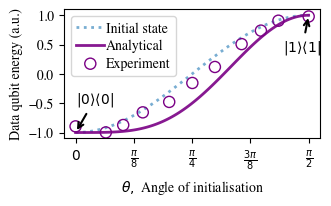

Saving: plots/n=3.pdf


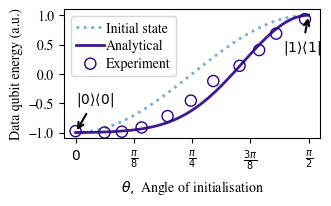

Saving: plots/n=4.pdf


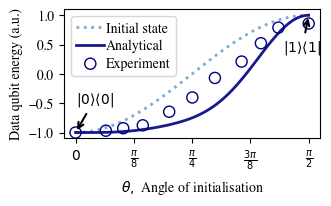

In [12]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.linalg import expm

# --- Plot/text config: use mathtext, not external LaTeX ---
mpl.rcParams['text.usetex'] = False

# --- Setup ---
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
thetas = np.linspace(0.0, 1.0, 100)
xvals = thetas * (np.pi / 2)  # angle in radians for plotting

ket0 = np.array([[1.0], [0.0]], dtype=complex)
psis = np.array([expm(-1j * np.pi/2 * sigma_x * t) @ ket0 for t in thetas])

state_0 = np.array([1.0, 0.0], dtype=complex)
target_fidelity = None  # use None to skip horizontal reference line

# --- Robust fidelity helper ---
def fidelity_with_0(state):
    psi = np.ravel(state).astype(complex)  # shape (2,)
    amp = np.vdot(state_0, psi)            # <0|psi>
    return float(np.real_if_close(abs(amp)**2))

# --- Initial state fidelities (not directly used here but available) ---
fidelities_original = np.array([fidelity_with_0(psi) for psi in psis])

# --- Reasonable line-search grid for GCI (interior points!) ---
s_grid = np.linspace(0.0, 1.0, 101)

# --- Initial energies (force to real) ---
res_init = []
for psi in psis:
    E = GCI(initial_psi, psi, 1, s_grid).execute_gci()[0][-1]
    res_init.append(float(np.real_if_close(E)))
res_init = np.array(res_init)

# --- DB-QITE results: keep energies, ensure real; graceful fallback for s_vals ---
def run_dbqite(label_map, k, psis):
    results = {}
    for M, label in label_map.items():
        try:
            s_vals = optimal_s_Mk[M-1][:k]
            if len(s_vals) == 0:
                s_vals = s_grid
        except Exception:
            s_vals = s_grid

        energies = []
        for psi in psis:
            E = GCI(QITE_dme_select_M(M), psi, None, s_vals).execute_gci()[0][-1]
            energies.append(float(np.real_if_close(E)))
        results[label] = np.array(energies)
    return results

dict_fid_RGCI_1 = run_dbqite({1: r'$n=2$', 2: r'$n=3$'}, k=1, psis=psis)
dict_fid_RGCI_2 = run_dbqite({1: r'$n=4$'}, k=2, psis=psis)

# --- Style and external/exp data config ---
# colors  = ['#7a0085', '#2c0084', '#006f7a', 'C0']




colors = ['#7a0085', '#2c0084', '#000080', 'C0']   # Prussian Blue
# markers = ['o', 'o', 's', '^']  # ensure enough markers
markers = ['o', 'o', 'o', '^']  # ensure enough markers

ticks = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]
tick_labels = [r'$0$', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$']

# If you have experimental data arrays defined, keep as-is; else this block won't plot them.
# Expected shapes: theta_* in radians, energy_* numeric arrays.
exp_data = {
    r'$n=2$': ('theta_exp_a', 'energy_exp_a', "#45C7FF"),
    r'$n=3$': ('theta_exp_b', 'energy_exp_b', "#5845FF"),
    r'$n=4$': ('theta_exp_c', 'energy_exp_c', "C2"),
}

def _maybe_get_exp(name):
    """Return (x, y, color) arrays if variables exist in globals(), else None."""
    if name not in exp_data:
        return None
    theta_name, energy_name, color_exp = exp_data[name]
    x = globals().get(theta_name, None)
    y = globals().get(energy_name, None)
    if x is None or y is None:
        return None
    return (np.asarray(x, dtype=float), np.asarray(y, dtype=float), color_exp)

# --- Safe saving dir ---
os.makedirs('plots', exist_ok=True)

def save_single_plot(label, ydata, idx):
    fig, ax = plt.subplots()
    fig.patch.set_alpha(0)
    ax.set_facecolor('white')

    # Initial curve
    ax.plot(xvals, res_init, label=r"Initial state",
            color='C0', linestyle=':', alpha=0.6)

    # Analytical (this method) curve
    ax.plot(xvals, np.asarray(ydata, dtype=float), label='Analytical',
            color=colors[idx % len(colors)], alpha=0.9)

    # Optional reference line if provided
    if target_fidelity is not None and np.isfinite(target_fidelity):
        ax.axhline(y=float(target_fidelity), color='k', alpha=0.6, linestyle='--')

    ax.set_xlabel(r'$\theta,$ Angle of initialisation')
    ax.set_ylabel('Data qubit energy (a.u.)')
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)

    ax.set_ylim(-1.1, 1.1)   # top at 1, bottom at -1

    # Add more ticks to y-axis
    import matplotlib.ticker as ticker
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # increase ticks

    # Annotations use res_init as reference
    ax.annotate(r'$|1\rangle\langle 1|$',
                xy=(xvals[-1], res_init[-1]),
                xytext=(xvals[-1]-0.17, res_init[-1]-0.6),
                arrowprops=dict(arrowstyle='->', lw=1.5), zorder=10)

    ax.annotate(r'$|0\rangle\langle 0|$',
                xy=(xvals[0], res_init[0]),
                xytext=(xvals[0], res_init[0]+0.5),
                arrowprops=dict(arrowstyle='->', lw=1.5), zorder=10)

    # Experimental points (only if the arrays exist)
    maybe = _maybe_get_exp(label)
    if maybe is not None:
        x_exp, y_exp, color_exp = maybe
        # Unfilled markers: use edgecolors for visibility, facecolors='none'
        ax.scatter(x_exp, y_exp, label='Experiment',
                   marker=markers[idx % len(markers)],
                   facecolors='none', edgecolors=colors[idx % len(colors)],
                   zorder=4)

    ax.legend(fontsize=10)
    plt.tight_layout()

    # Build a safe filename from label (strip TeX, spaces, commas)
    safe_label = (label.replace(' ', '_')
                        .replace(',', '')
                        .replace('\n', '')
                        .replace('$', '')
                        .replace('{', '')
                        .replace('}', '')
                        .replace('\\', '')
                        .replace('(', '')
                        .replace(')', ''))
    fname = f'plots/{safe_label}.pdf'
    print(f"Saving: {fname}")

    plt.savefig(fname, transparent=False)
    plt.show()
    plt.close()

# --- Generate the individual plots ---
i = 0
for label, y in dict_fid_RGCI_1.items():
    save_single_plot(label, y, i); i += 1
for label, y in dict_fid_RGCI_2.items():
    save_single_plot(label, y, i); i += 1